<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Use TensorFlow to predict handwritten digits</b></font></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
</table>

This notebook contains steps and code to demonstrate Deep Learning model training and scoring in the Watson Machine Learning service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3 and <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

-  Work with Watson Machine Learning experiments to train Deep Learning models (Tensorflow)
-  Save trained models in the Watson Machine Learning repository
-  Deploy a trained model online and score


## Contents

1.	[Set up](#setup)
2.	[Create the training definitions](#model)
3.  [Train the model](#train)
3.	[Save the model](#save)
4.	[Create the online deployment](#deploy)
5.	[Score data](#score)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up

Before you use the sample code in this notebook, you must perform the following setup tasks:
-  Create a <a href="https://cocl.us/Watson-Studio-ML0120EN-Edx" target="_blank" rel="noopener no referrer">Watson Studio Service</a>.
-  Create a <a href="https://cocl.us/Watson-Machine-Learning-ML0120EN-Edx" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance is <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://cocl.us/Cloud-Object-Storage-ML0120EN-Edx" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage is <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to Watson Studios, click the button on the top left corner.
    - Select Data Services
    - Go to your COS(Cloud Object Storage) dashboard.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

### 1.1 Work with Cloud Object Storage  (COS)

Install the boto library. This library allows Python developers to manage Cloud Object Storage (COS).

**Tip:** If `ibm_boto3` is not preinstalled in you environment, run the following command to install it: 

In [1]:
# Run the command if ibm_boto3 is not installed.
!pip install ibm-cos-sdk

     |████████████████████████████████| 61kB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 768kB 9.8MB/s eta 0:00:01
     |████████████████████████████████| 225kB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 552kB 6.3MB/s eta 0:00:01    |████▉                           | 81kB 6.8MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5
  Stored in directory: /home/jovyan/.cache/pip/wheels/75/93/e6/23071b2c037147a0993d34b64a03e51abca84435fc9cd6a278
  Stored in directory: /home/jovyan/.cache/pip/wheels/23/d9/d7/43fd95b014eed89466154d8373bf4cffbb3d972de7841e213c
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer


In [2]:
# Install the boto library.
import ibm_boto3
from ibm_botocore.client import Config

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** the HMAC key.

- To get your HMAC key: 
    - Go to Watson Studios, click the button on the top left corner.
    - Select Data Services
    - Go to your COS(Cloud Object Storage) dashboard.
    - In the **Service credentials** click on **View credentials** (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

In [3]:
cos_credentials = {
  "apikey": "G3GJcnr2kGdWyq2G0ZSpLshr8a24Ta48JjhgLRivfbgn",
  "cos_hmac_keys": {
    "access_key_id": "bcf61a7de65244ac857e5450fa7ce463",
    "secret_access_key": "864d554cd7ebef235420df903fa9a5e6ea4421deb22cedd5"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/20cf85337b99434a95ba2b141886466e:5a2b6b97-3e86-4207-b1de-9b662eac74e3::",
  "iam_apikey_name": "auto-generated-apikey-bcf61a7d-e652-44ac-857e-5450fa7ce463",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/20cf85337b99434a95ba2b141886466e::serviceid:ServiceId-60baddca-cb05-4713-a43a-7f2365eb5033",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/20cf85337b99434a95ba2b141886466e:5a2b6b97-3e86-4207-b1de-9b662eac74e3::"
}

In [ ]:
# The code was removed by Watson Studio for sharing.

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then enter it in the cell below:

In [4]:
# Define endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [5]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Create a Boto resource to be able to write data to COS.

In [6]:
# Create a COS resource.
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [7]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-094fdaad-c29e-46dc-8abc-00cc1e60140e"...
Creating bucket "training-results-094fdaad-c29e-46dc-8abc-00cc1e60140e"...


Now you should have 2 buckets.

In [8]:
# Display a list of created buckets.
print(list(cos.buckets.all()))

[s3.Bucket(name='digitclassifier-donotdelete-pr-q15kngesiapedz'), s3.Bucket(name='training-data-094fdaad-c29e-46dc-8abc-00cc1e60140e'), s3.Bucket(name='training-results-094fdaad-c29e-46dc-8abc-00cc1e60140e')]


### 1.2 Download the training data and upload it to the COS buckets

Download the training data and upload it to the 'training-data' bucket.
First, create a list of links for the training data set.

In [9]:
# Create a list of links.
data_links = ['https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/train-images-idx3-ubyte.gz',
              'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/train-labels-idx1-ubyte.gz',
              'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/t10k-images-idx3-ubyte.gz',
              'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/t10k-labels-idx1-ubyte.gz']

The code in the next cell uploads files from links to your COS.

In [10]:
# Upload files from the links to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Have a look at the list of the created buckets and their contents.

In [11]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-094fdaad-c29e-46dc-8abc-00cc1e60140e
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-094fdaad-c29e-46dc-8abc-00cc1e60140e


You are done with COS, and you are ready to train your model!

### 1.3. Work with the WML service instance

Import the libraries you need to work with your WML instance.

**Hint:** You may also need to install `wget` using the following command `!pip install wget`

In [12]:
!pip install wget

  Stored in directory: /home/jovyan/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [13]:
import urllib3, requests, json, base64, time, os, wget

Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

In [14]:
wml_credentials = {
  "apikey": "pIFaFqASWOGHoAtWAZIaSYfS_xEhAYTEtUJnAxMEDqlD",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/20cf85337b99434a95ba2b141886466e:91a35b53-d3a3-48b1-9eba-0922f333fa20::",
  "iam_apikey_name": "auto-generated-apikey-aaf8a72e-b930-46d0-b1a9-6b405a9f9724",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/20cf85337b99434a95ba2b141886466e::serviceid:ServiceId-c3f4527b-e310-4fe6-972e-43e1f4cf5d22",
  "instance_id": "91a35b53-d3a3-48b1-9eba-0922f333fa20",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [ ]:
# The code was removed by Watson Studio for sharing.

#### Install the `watson-machine-learning-client` library from pypi.

In [15]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [16]:
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 542kB 8.4MB/s eta 0:00:01     |███████████▋                    | 194kB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 51kB 15.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 14.0MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
Successfully built tabulate


#### Import the `watson-machine-learning-client` and authenticate to the service instance.

In [17]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Note:** A deprecation warning is returned from scikit-learn package that does not impact watson machine learning client functionalities.

In [18]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [19]:
# Display the client version number.
print(client.version)

1.0.378


**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener noreferrer">here</a>.

<a id="model"></a>
## 2. Create the training definitions

In this section you:

- [2.1 Prepare the training definition metadata](#prep)
- [2.2 Get the sample model definition content files from Git](#get)
- [2.3 Store the training definition in the WML repository](#store)



### 2.1 Prepare the training definition metadata<a id="prep"></a>

In [37]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "Digit recognition model",
            client.repository.DefinitionMetaNames.DESCRIPTION: "See above",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "Chris Goldman",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.13",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.6",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

### 2.2 Get the sample model definition content file from Git <a id="get"></a>

In [21]:
filename='tf-softmax-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip')
    
print(filename)

tf-softmax-model.zip


### 2.3 Store the training definition in the WML repository<a id="store"></a>

In [38]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [39]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [40]:
# Display the training definition uid.
print(definition_uid)

54444a70-6d33-4817-b507-130cca5008a6


## 3. Train the model<a id="train"></a>

In this section, learn how to:
- [3.1 Enter training configuration metadata](#meta)
- [3.2 Train the model in the background](#backg)
- [3.3 Monitor the training log](#log)
- [3.4 Cancel the training run](#cancel)


### 3.1 Enter training configuration metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where trained model will be saved.

**Note** Your COS credentials are referenced in this code.


In [41]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Digit recognition model", 
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "Chris Goldman",              
            client.training.ConfigurationMetaNames.DESCRIPTION: "See above",
            client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {"name": "k80"},
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
                    "connection": {
                        "endpoint_url": service_endpoint,
                        "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                        "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                    },
                    "source": {
                        "bucket": buckets[0],
                    },
                    "type": "s3"
                },
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                "connection": {
                    "endpoint_url": service_endpoint,
                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                },
                "target": {
                    "bucket": buckets[1],
                },
                "type": "s3"
            },
        }

### 3.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, set the optional parameter `asynchronous=True` (or remove it). In this case the parameter has been removed. 

**Note:** To run the training in **active** mode, set `asynchronous=False`.

In [42]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [43]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

Check the status of the training run by calling the method the next cell:

In [44]:
# Get training run status.
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "current_at": "2020-01-10T20:54:31.066Z",
  "message": "training-45-z5FEWR: Submitted",
  "metrics": [],
  "state": "pending",
  "submitted_at": "2020-01-10T20:54:29.011Z"
}


### 3.3  Monitor the training log<a id="log"></a>

Run the cell below to monitor the training log.

In [45]:
client.training.monitor_logs(training_run_guid_async)



####################################################

Log monitor started for training run: model-93d59hfc

####################################################


training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FEWR: 
training-45-z5FE

### 3.4 Cancel the training run<a id="cancel"></a>

You can cancel the training run by calling the method below.

<a id="save"></a>
## 4. Save the model

#### Call this method to the save model to the WML repository.

In [46]:
# Save model to WML repository.
saved_model_details = client.repository.store_model(training_run_guid_async, {"name": "My cool mnist model"})

In [47]:
# Display location of saved model.
print("Url: " + client.repository.get_model_url(saved_model_details))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/published_models/1d7d2304-0087-4b7e-803e-5113365bb256


In [48]:
saved_model_details

{'metadata': {'guid': '1d7d2304-0087-4b7e-803e-5113365bb256',
  'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/published_models/1d7d2304-0087-4b7e-803e-5113365bb256',
  'created_at': '2020-01-10T21:56:05.048Z',
  'modified_at': '2020-01-10T21:56:05.118Z'},
 'entity': {'runtime_environment': 'None Provided',
  'learning_configuration_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/published_models/1d7d2304-0087-4b7e-803e-5113365bb256/learning_configuration',
  'name': 'My cool mnist model',
  'description': 'See above',
  'learning_iterations_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/published_models/1d7d2304-0087-4b7e-803e-5113365bb256/learning_iterations',
  'feedback_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/published_models/1d7d2304-0087-4b7e-803e-5113365bb256/feedback',
  'latest_ver

**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [49]:
# Get and display model uid.
model_uid = client.repository.get_model_uid(saved_model_details)
print("Saved model uid: " + model_uid)

Saved model uid: 1d7d2304-0087-4b7e-803e-5113365bb256


#### List the stored models.

In [50]:
client.repository.list_models()

------------------------------------  -------------------  ------------------------  ---------------
GUID                                  NAME                 CREATED                   FRAMEWORK
1d7d2304-0087-4b7e-803e-5113365bb256  My cool mnist model  2020-01-10T21:56:05.048Z  tensorflow-1.13
------------------------------------  -------------------  ------------------------  ---------------


#### Delete the training run and its results.

Run the code in the cell below to delete train runs and results:

In [52]:
client.training.delete(training_run_guid_async)

'SUCCESS'

## 5. Create the online deployment<a id="deploy"></a>

Run the code in the following cell to deploy the stored model as a web service (online):

In [53]:
# Create online deployment.
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")



#######################################################################################

Synchronous deployment creation for uid: '1d7d2304-0087-4b7e-803e-5113365bb256' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='0b7e5589-f03e-4ca7-a8ac-633185e64522'
------------------------------------------------------------------------------------------------




## 6. Score data<a id="score"></a>

Now, extract the url endpoint, scoring_url, which will be used to send scoring requests.

In [54]:
#  Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/91a35b53-d3a3-48b1-9eba-0922f333fa20/deployments/0b7e5589-f03e-4ca7-a8ac-633185e64522/online


Prepare sample scoring data to score deployed model.

In [55]:
image1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,0.757,0.596,0.361,0.200,0.200,0.200,0.200,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.992,0.988,0.992,0.988,0.992,0.988,0.992,0.753,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.082,0.400,0.243,0.400,0.400,0.239,0.718,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.361,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.678,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.992,0.988,0.875,0.796,0.796,0.796,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.482,0.996,0.992,0.878,0.796,0.796,0.875,0.996,0.278,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.953,0.992,0.510,0.078,0.000,0.000,0.078,0.992,0.910,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.596,0.992,0.718,0.000,0.000,0.000,0.000,0.000,0.518,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.592,0.078,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.322,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.757,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.796,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.996,0.992,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.400,0.000,0.000,0.000,0.000,0.000,0.082,0.796,0.992,0.510,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.482,0.000,0.000,0.000,0.000,0.161,0.678,0.992,0.796,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.635,0.875,0.400,0.082,0.400,0.639,0.953,0.992,0.671,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.918,0.992,1.000,0.992,1.000,0.675,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.514,0.753,0.435,0.196,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
image2 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.878,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.475,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.580,0.659,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.765,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.376,0.824,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.988,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.447,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.176,0.925,0.851,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.753,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659,0.969,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,1.000,0.992,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.949,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.553,0.992,0.741,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.910,0.980,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.882,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.525,0.988,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.988,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.800,0.820,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.992,0.992,0.420,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.780,0.333,0.333,0.333,0.333,0.506,0.643,0.765,0.988,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.667,0.961,0.988,0.988,0.988,0.988,0.910,0.906,0.984,0.988,0.988,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.192,0.329,0.329,0.329,0.329,0.000,0.000,0.631,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.502,0.992,0.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.529,0.988,0.957,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.910,0.925,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.702,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

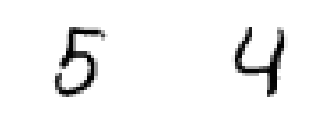

In [57]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build a scoring dictionary consisting of two digits and send it to the deployed model to get predictions.

In [58]:
# Build scoring dictionary which has two digits (image1 and image29.
scoring_data = {'values': [image1, image2]}

In [59]:
# send scoring dictionary to deployed model to get predictions
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [5, 4]}


In [60]:
client.deployments.list()

------------------------------------  ----------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                    TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
0b7e5589-f03e-4ca7-a8ac-633185e64522  Mnist model deployment  online  DEPLOY_SUCCESS  2020-01-10T22:00:02.728Z  tensorflow-1.13  model
------------------------------------  ----------------------  ------  --------------  ------------------------  ---------------  -------------


<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use `watson-machine-learning-client` to train and score TensorFlow models. 
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for a <a href="https://dataplatform.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">tutorial</a> and more samples, documentation, how-tos, and blog posts. 

### Citations
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increase the clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>